In [63]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
        
        
#initialize left and right lane objects to store lane data
leftLane = Line()
rightLane = Line()

In [2]:
def undistort(img, img_path=0):
    
    # Read in the saved camera calibration result
    dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

    # performs image distortion correction and
    # returns the undistorted image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if img_path:
        img_name = img_path[len('test_images/'):]
        cv2.imwrite('output_images/undistort_' + img_name, img_out)
        
    return undist



In [3]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, channel, thresh=(0, 255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h_channel = hls[:, :, 0]
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]

    binary_output = np.zeros_like(s_channel)

    if channel == 0:
        binary_output[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1
    if channel == 1:
        binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    if channel == 2:
        binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return binary_output

def rgb_select(img, channel, thresh=(200, 255)):

    r_channel = img[:, :, 0]
    g_channel = img[:, :, 1]
    b_channel = img[:, :, 2]

    binary_output = np.zeros_like(r_channel)

    if channel == 0:
        binary_output[(r_channel > thresh[0]) & (r_channel <= thresh[1])] = 1

    if channel == 1:
        binary_output[(g_channel > thresh[0]) & (g_channel <= thresh[1])] = 1

    if channel == 2:
        binary_output[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1

    return binary_output

def transform(image, img_path=0):
    # img is the undistorted image
    # if img_path is given (must be some image in 'test_images/)
    # all transformed images will be saved to output_images
    
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 150))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 150))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary  = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

    h_binary = hls_select(image, 0, thresh=(15, 100))
    l_binary = hls_select(image, 1, thresh=(90, 255))
    s_binary = hls_select(image, 2, thresh=(90, 255))

    r_binary = rgb_select(image, 0, thresh=(200, 255))
    g_binary = rgb_select(image, 1, thresh=(200, 255))
    b_binary = rgb_select(image, 2, thresh=(200, 255))


    binary_out = np.zeros_like(s_binary)
    binary_out[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((s_binary == 1) & (l_binary == 1) )] = 1

    # if path is given then print transformed images
    if(img_path):

        img_name = img_path[len('test_images/'):]

        #initialize the image
        img_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)

        #copy the activated pixels into the new black image
        img_out = 255*gradx
        #save image
        cv2.imwrite('output_images/gradx_' + img_name, img_out)

        #do the same for the other transforms

        img_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        img_out = 255 * grady
        cv2.imwrite('output_images/grady_' + img_name, img_out)

        img_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        img_out = 255 * mag_binary
        cv2.imwrite('output_images/mag_binary' + img_name, img_out)

        img_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        img_out = 255 * dir_binary
        cv2.imwrite('output_images/dir_binary_' + img_name, img_out)

        img_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        img_out = 255 * s_binary
        cv2.imwrite('output_images/s_binary_' + img_name, img_out)

        img_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        img_out = 255 * h_binary
        cv2.imwrite('output_images/h_binary_' + img_name, img_out)

        img_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        img_out = 255 * l_binary
        cv2.imwrite('output_images/l_binary_' + img_name, img_out)

        img_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        img_out = 255 * r_binary
        cv2.imwrite('output_images/r_binary_' + img_name, img_out)

        img_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        img_out = 255 * g_binary
        cv2.imwrite('output_images/g_binary_' + img_name, img_out)

        img_out = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
        img_out = 255 * b_binary
        cv2.imwrite('output_images/b_binary_' + img_name, img_out)

        #save original hls channels
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        h_channel = hls[:, :, 0]
        cv2.imwrite('output_images/h_channel' + img_name, h_channel)
        l_channel = hls[:, :, 1]
        cv2.imwrite('output_images/l_channel' + img_name, l_channel)
        s_channel = hls[:, :, 2]
        cv2.imwrite('output_images/s_channel_' + img_name, s_channel)

        #save the combined image
        img_out = binary_out
        img_out = 255 * img_out
        cv2.imwrite('output_images/combined_binary_' + img_name, img_out)

    return binary_out



In [4]:
def warper(img, src, dst, img_path=0):
    #warps the transformed image    
    
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    
    #print the image if img_path is given (assuming some image in 'test_images/')
    if img_path:
        img_name = fname[len('test_images/'):]
        cv2.imwrite('output_images/warped_'+ img_name, warped*255)
    
    return warped

def src_dst_points(img):
    
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 95],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 57), img_size[1] / 2 + 95]])
    
    dst = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    
    return src, dst


In [5]:
#test perspective transform and warp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#first open the image
#img = cv2.imread('test_images/straight_lines1.jpg')
#img = mpimg.imread('test_images/straight_lines1.jpg')
img = mpimg.imread('test_images/test4.jpg')
print('Image type:', img.dtype, 'Image shape:', img.shape)
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(24, 9))
ax.imshow(img_show)


Image type: uint8 Image shape: (720, 1280, 3)


Image type: uint8 Image shape: (720, 1280, 3)


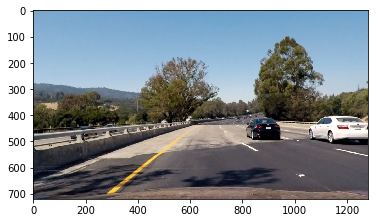

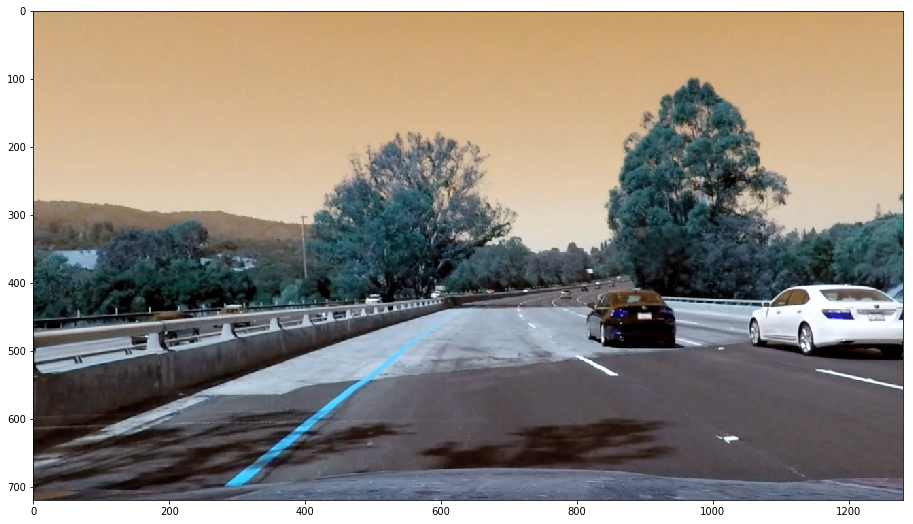

In [6]:
#undistort image using previous camera calibration parameters
undistorted_img = undistort(img)
print('Image type:', undistorted_img.dtype, 'Image shape:', undistorted_img.shape)
plt.imshow(undistorted_img)
#show the result
img_show = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(24, 9))
ax.imshow(img_show)

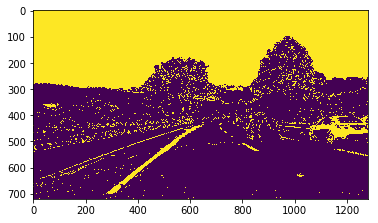

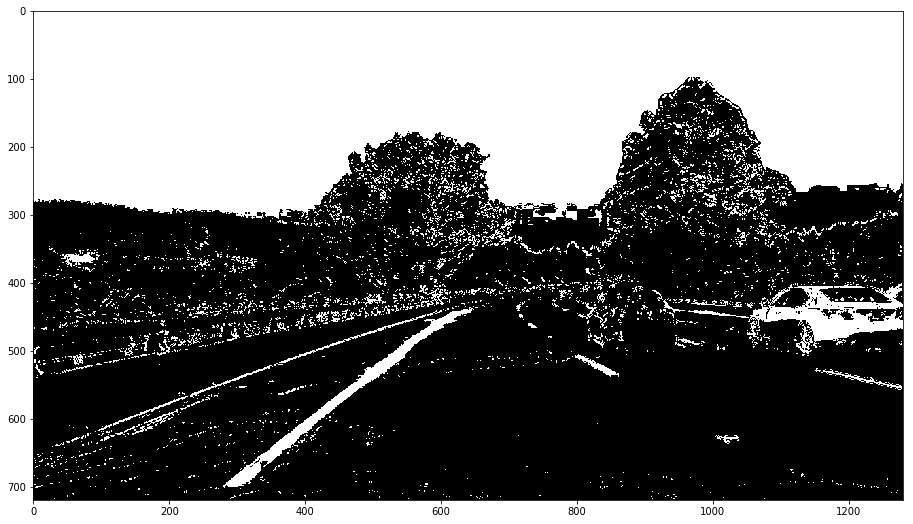

In [7]:
#apply gradient and color transform and return a thresholded binary image
t_img_binary = transform(undistorted_img)
#print('Image type:', t_img_binary.dtype, 'Image shape:', t_img_binary.shape)
plt.imshow(t_img_binary)
#show the result
fig, ax = plt.subplots(figsize=(24, 9))
ax.imshow(t_img_binary, cmap='gray')


In [8]:
#get source and destination points needed to apply the perpective transform
src, dst = src_dst_points(img)
#print('source', src)
#print('dest', dst)

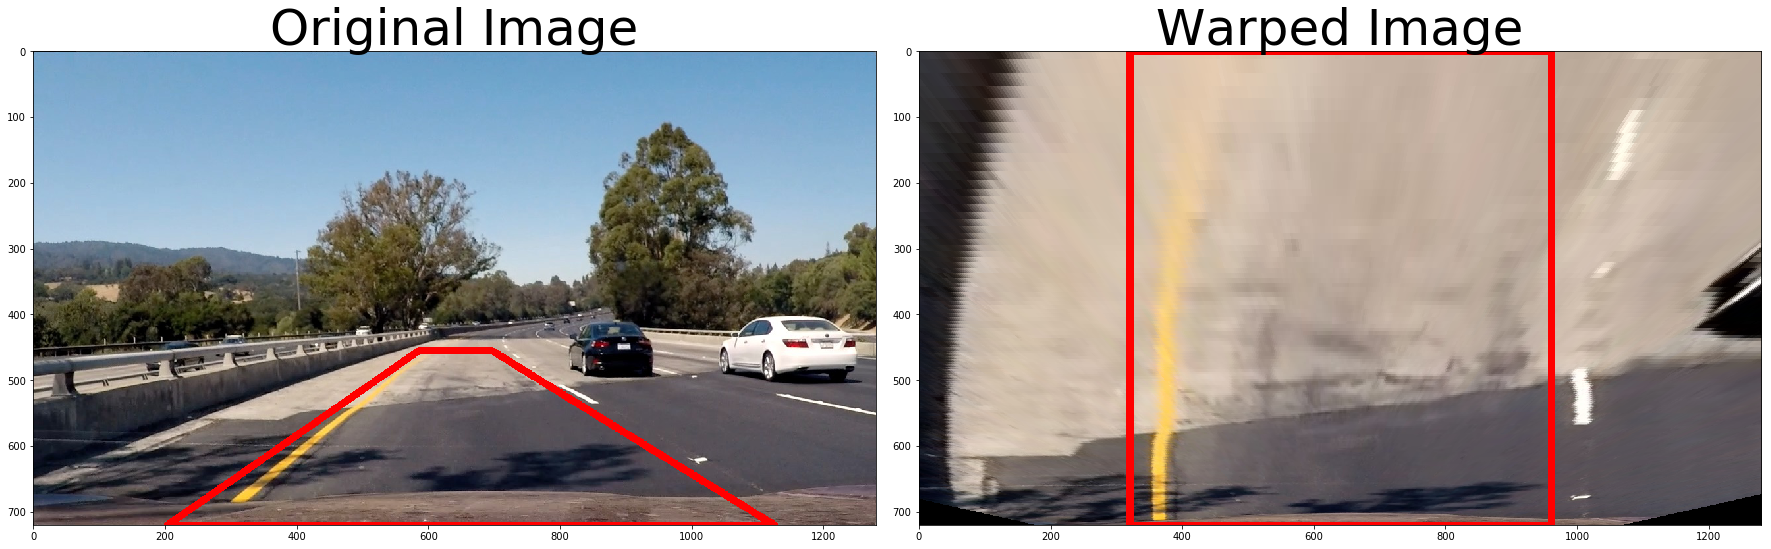

In [9]:
def draw_rectangle(img, pts):
    cv2.line(img,(pts[0,0],pts[0,1]),(pts[1,0], pts[1,1]),(255,0,0),10) #draw the line
    cv2.line(img,(pts[1,0],pts[1,1]),(pts[2,0], pts[2,1]),(255,0,0),10) #draw the line
    cv2.line(img,(pts[2,0],pts[2,1]),(pts[3,0], pts[3,1]),(255,0,0),10) #draw the line
    cv2.line(img,(pts[3,0],pts[3,1]),(pts[0,0], pts[0,1]),(255,0,0),10) #draw the line
    return img


warped_img = warper(undistorted_img, src, dst)

warped_img_rect = draw_rectangle(warped_img, dst)

img_copy = draw_rectangle(img, src)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

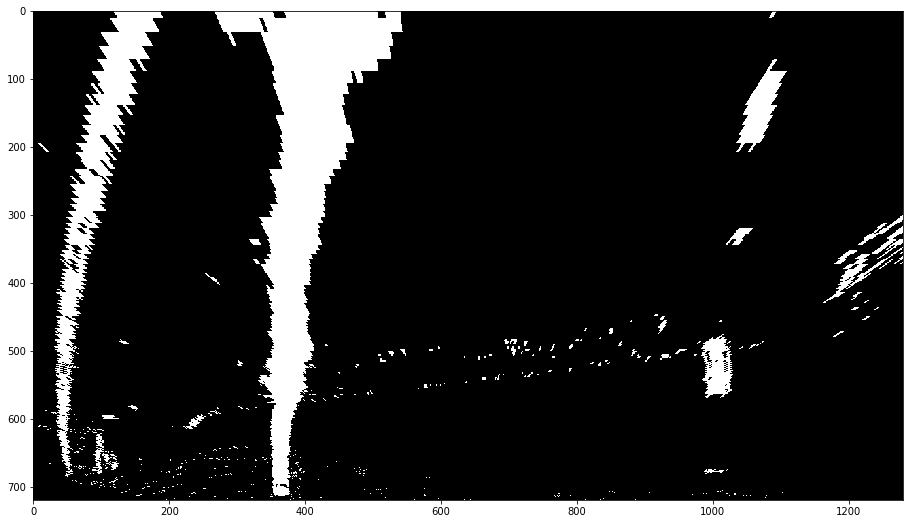

In [10]:
#after verifying that the chosen src and dst points transform the image to have more or less parallel lines
#I can now make a histogram of the pixels in the perspective transformed imaged

#first apply the perspective transform to the thresholded binary image
warped_t_binary = warper(t_img_binary, src, dst)

#show the result
fig, ax = plt.subplots(figsize=(24, 9))
ax.imshow(warped_t_binary, cmap='gray')



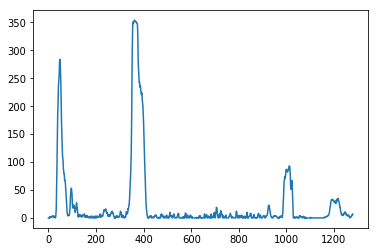

In [11]:
def hist(img):

    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0] // 2:, :]
    # Take a histogram of the bottom half of the image
    histogram = np.sum(bottom_half, axis=0)

    return histogram

histogram = hist(warped_t_binary)
#show the result
plt.plot(histogram)


In [112]:
def search_around_poly(binary_warped, visual=0):
    # define the search margin around the existing fit to find new pixels
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (leftLane.current_fit[0]*(nonzeroy**2) + leftLane.current_fit[1]*nonzeroy + 
                    leftLane.current_fit[2] - margin)) & (nonzerox < (leftLane.current_fit[0]*(nonzeroy**2) + 
                    leftLane.current_fit[1]*nonzeroy + leftLane.current_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (rightLane.current_fit[0]*(nonzeroy**2) + rightLane.current_fit[1]*nonzeroy + 
                    rightLane.current_fit[2] - margin)) & (nonzerox < (rightLane.current_fit[0]*(nonzeroy**2) + 
                    rightLane.current_fit[1]*nonzeroy + rightLane.current_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
 
    return leftx, lefty, rightx, righty

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 3) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, visual=0):
         
    # Find our lane pixels first
    if (leftLane.detected and rightLane.detected):
        leftx, lefty, rightx, righty = search_around_poly(binary_warped)
        
    else: #no previous fit was found in last frame, search for pixels again before fiting
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try: #try fit for left lane
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # was the line detected in the last iteration?
        leftLane.detected = True
        # x values of the last n fits of the line
        leftLane.recent_xfitted = left_fitx
     
        #average x values of the fitted line over the last n iterations
        leftLane.bestx = np.sum(leftLane.recent_xfitted)/len(leftLane.recent_xfitted)
        
        #polynomial coefficients averaged over the last n iterations
        if (leftLane.best_fit):
            leftLane.best_fit = (np.mean(left_fit) + leftLane.best_fit) / 2
        else:
            leftLane.best_fit = np.mean(left_fit)
            
        #polynomial coefficients for the most recent fit
        leftLane.current_fit = np.array([left_fit[0],left_fit[1],left_fit[2]])
    
        #x values for detected line pixels
        leftLane.allx = leftx  
        #y values for detected line pixels
        leftLane.ally = lefty    

        # was the line detected in the last iteration?
        rightLane.detected = True
        
        # x values of the last n fits of the line
        rightLane.recent_xfitted = right_fitx
        
        #average x values of the fitted line over the last n iterations
        rightLane.bestx = np.sum(rightLane.recent_xfitted)/len(rightLane.recent_xfitted)
        
        #polynomial coefficients averaged over the last n iterations
        if (rightLane.best_fit):
            rightLane.best_fit = (np.mean(right_fit) + rightLane.best_fit) / 2
        else:
            rightLane.best_fit = np.mean(right_fit)
            
        #polynomial coefficients for the most recent fit
        rightLane.current_fit = np.array([right_fit[0],right_fit[1],right_fit[2]])  
        
        #x values for detected line pixels
        rightLane.allx = rightx  
        #y values for detected line pixels
        rightLane.ally = righty
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        # was the line detected in the last iteration?
        leftLane.detected = False
        right_fitx = 1*ploty**2 + 1*ploty
        rightLane.detected = False
            
    #if(visual):
        ## Visualization ##
        
    return 0


In [113]:
# after creating an histogram we can find the starting x points for each lane, 
# apply the sliding window algorithm to find the coordinates of the pixels that are part of the lanes
# and fit a sencod order polinomial to to the pixels found
out_img = fit_polynomial(warped_t_binary, 1)


In [114]:
def measure_curvature_pixels(img_shape):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
 
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = img_shape[0]-1
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # fit a polynomial taking into account meters/pixel
    left_fit_cr = np.polyfit(leftLane.ally*ym_per_pix, leftLane.allx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(rightLane.ally*ym_per_pix, rightLane.allx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    r = (left_curverad + right_curverad) / 2
    
    # the offset position of the car with respect to the center of the lane
    # is the offset of the lane center from the center of the image
    offset = (img_shape[1]/2-(leftLane.bestx + rightLane.bestx)/ 2)*3.7/700
    
    #save new values to right and left lane objects
    #radius of curvature of the line in some units
    leftLane.radius_of_curvature = left_curverad
    rightLane.radius_of_curvature = right_curverad 
    #distance in meters of vehicle center from the line
    leftLane.line_base_pos = rightLane.line_base_pos = offset
    #print ('radius', r,'m', 'offset:', offset, "m")
    return

# Calculate the radius of curvature in meters for both lane lines
measure_curvature_pixels(img.shape)

In [128]:
def draw_lanes_text(warped_t_binary, undistorted_img, dst, src):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_t_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_t_binary.shape[0]-1, warped_t_binary.shape[0] )
        
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftLane.recent_xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightLane.recent_xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_t_binary.shape[1], warped_t_binary.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    #write the radius and offset info on the image
    r = (leftLane.radius_of_curvature + rightLane.radius_of_curvature) / 2
    r_text='Radius of curvature: {:4f} (m)'.format(r)
    offset_text = 'Offset: {:4f}(m)'.format(leftLane.line_base_pos)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,r_text, (10, 40),font, 1, (255, 255, 255), 2) 
    cv2.putText(result,offset_text, (10, 100),font, 1, (255, 255, 255), 2)
    
    return result



In [121]:
#pipeline for processing the image frames of a video
def process_image(image):
    
    #undistort image using previous camera calibration parameters
    undistorted_img = undistort(image)
    #apply gradient and color transform and returnt a thresholded binary image
    t_img_binary = transform(undistorted_img)
    #get source and destination points needed to apply the perpective transform
    src, dst = src_dst_points(image)
    #apply the perspective transform to the thresholded binary image
    warped_t_binary = warper(t_img_binary, src, dst)
    # apply the sliding window algorithm to find the coordinates of the pixels that are part of the lanes
    # and fit a sencod order polinomial to to the pixels found
    fitted_img = fit_polynomial(warped_t_binary)
    # Calculate the radius of curvature in meters for both lane lines
    measure_curvature_pixels(image.shape)
    #draw the identified lane, radius and offset on the image
    result = draw_lanes_text(warped_t_binary, undistorted_img, dst, src)
    return result

In [123]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [129]:
#will save video to output_videos
video_output = 'output_videos/project_video.mp4'
#open project_video.mp4
clip1 = VideoFileClip("project_video.mp4")
#process the video frames
clip = clip1.fl_image(process_image) 
#write the edited video
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [08:16<00:00,  2.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 4min 59s, sys: 1min 10s, total: 6min 9s
Wall time: 8min 19s


In [130]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [131]:
#will save video to output_videos
video_output = 'output_videos/challenge_video.mp4'
#open project_video.mp4
clip1 = VideoFileClip("challenge_video.mp4")
#process the video frames
clip = clip1.fl_image(process_image) 
#write the edited video
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [03:06<00:00,  2.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 1min 53s, sys: 27.3 s, total: 2min 21s
Wall time: 3min 9s


In [132]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [133]:
#will save video to output_videos
video_output = 'output_videos/harder_challenge_video.mp4'
#open project_video.mp4
clip1 = VideoFileClip("harder_challenge_video.mp4")
#process the video frames
clip = clip1.fl_image(process_image) 
#write the edited video
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [08:50<00:00,  2.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

CPU times: user 5min 14s, sys: 59.5 s, total: 6min 13s
Wall time: 8min 55s


In [134]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))